In [165]:
from pandas_profiling import ProfileReport
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [114]:
train = pd.read_csv('train_ctrUa4K.csv')
test = pd.read_csv('test_lAUu6dG.csv')

In [115]:
profile = ProfileReport(train, title='Train Profile')

In [116]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [117]:
profile_test = ProfileReport(test, title='Test Profile')

In [118]:
profile_test

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We can see we have to do many things on the train and test set like impute missing values and convert categorical columns into numerical. It is best to combine both dataframes before all the preprocessing and just split them back into train and test sets later. I will add an additional column in the test set of the name loan_status, using which i will seperate it later.

In [119]:
test.Loan_Status = 'NA'

In [120]:
combined = pd.concat([train,test],ignore_index=True)

In [121]:
combined.shape

(981, 13)

In [122]:
combined.tail()

Loan_ID Gender Married Dependents     Education Self_Employed  \
976  LP002971   Male     Yes         3+  Not Graduate           Yes   
977  LP002975   Male     Yes          0      Graduate            No   
978  LP002980   Male      No          0      Graduate            No   
979  LP002986   Male     Yes          0      Graduate            No   
980  LP002989   Male      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
976             4009             1777.0       113.0             360.0   
977             4158              709.0       115.0             360.0   
978             3250             1993.0       126.0             360.0   
979             5000             2393.0       158.0             360.0   
980             9200                0.0        98.0             180.0   

     Credit_History Property_Area Loan_Status  
976             1.0         Urban         NaN  
977             1.0         Urban         NaN  
978             NaN     Semiurban         NaN  
979             1.0         Rural         NaN  
980             1.0         Rural         NaN

In [123]:
profile_combined = ProfileReport(combined,title="Entire Data")

In [124]:
profile_combined

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Missing Values

In [125]:
#Imputing Gender column with Male as it has more count of males
combined.Gender.fillna('Male',inplace=True)

In [126]:
#Imputing Married column with Yes as it has more count of yes
combined.Married.fillna('Yes',inplace=True)

In [127]:
#Imputing Self_Employed column with No as it has more count of no
combined.Self_Employed.fillna('No',inplace=True)

In [128]:
#Imputing LoanAmount column with the median of the column. Median is preferred to mean as the column is skewed.
combined['LoanAmount'].fillna(combined['LoanAmount'].median(), inplace=True)

In [129]:
#Imputing Credit_History with 2 as it can be a separate mark showing that history was not available
combined.Credit_History.fillna(2,inplace=True)

#### Notice that we are not doing imputation for Dependents and Loan_Amount_term columns. Reason being that we will be creating other features from these columns and drop the original columns.

### Feature Engineering

In [130]:
combined['Singleton'] = combined['Dependents'].map(lambda d: 1 if d=='1' else 0)
combined['Small_Family'] = combined['Dependents'].map(lambda d: 1 if d=='2' else 0)
combined['Large_Family'] = combined['Dependents'].map(lambda d: 1 if d=='3+' else 0)

In [131]:
combined.drop(['Dependents'], axis=1, inplace=True)

In [132]:
combined['Gender'] = combined['Gender'].map({'Male':1,'Female':0})

In [133]:
combined['Married'] = combined['Married'].map({'Yes':1,'No':0})

In [134]:
combined['Education'] = combined['Education'].map({'Graduate':1,'Not Graduate':0})

In [135]:
combined['Self_Employed'] = combined['Self_Employed'].map({'Yes':1,'No':0})

In [136]:
#ApplicantIncome and CoapplicantIncome are similar column so we'll combine them in a single column and drop the original 2 columns.
combined['Total_Income'] = combined['ApplicantIncome'] + combined['CoapplicantIncome']
combined.drop(['ApplicantIncome','CoapplicantIncome'], axis=1, inplace=True)

In [137]:
#We also create a debt to total income ratio
combined['Debt_Income_Ratio'] = combined['Total_Income'] / combined['LoanAmount']

In [138]:
combined['Very_Short_Term'] = combined['Loan_Amount_Term'].map(lambda t: 1 if t<=60 else 0)
combined['Short_Term'] = combined['Loan_Amount_Term'].map(lambda t: 1 if t>60 and t<180 else 0)
combined['Long_Term'] = combined['Loan_Amount_Term'].map(lambda t: 1 if t>=180 and t<=300  else 0)
combined['Very_Long_Term'] = combined['Loan_Amount_Term'].map(lambda t: 1 if t>300 else 0)
combined.drop('Loan_Amount_Term', axis=1, inplace=True)

In [139]:
combined['Credit_History_Bad'] = combined['Credit_History'].map(lambda c: 1 if c==0 else 0)
combined['Credit_History_Good'] = combined['Credit_History'].map(lambda c: 1 if c==1 else 0)
combined['Credit_History_Unknown'] = combined['Credit_History'].map(lambda c: 1 if c==2 else 0)
combined.drop('Credit_History', axis=1, inplace=True)

In [140]:
property_dummies = pd.get_dummies(combined['Property_Area'], prefix='Property',drop_first=True)
combined = pd.concat([combined, property_dummies], axis=1)
combined.drop('Property_Area', axis=1, inplace=True)

In [141]:
combined.drop('Loan_ID',1,inplace=True)

#### We saw that LoanAmount, TotalIncome and Debt_income_ratio are right skewed. Let's try taking their logarithmic values and see if they become normally distributed.

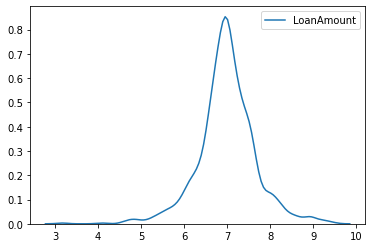

In [142]:
sns.kdeplot(np.log2(combined.LoanAmount))

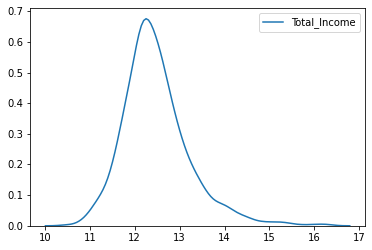

In [143]:
sns.kdeplot(np.log2(combined.Total_Income))

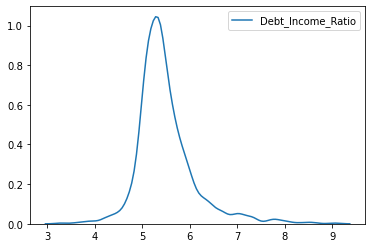

In [144]:
sns.kdeplot(np.log2(combined.Debt_Income_Ratio))

In [145]:
#As the 3 columns became normally distributed, we shall convert them into their log values.
combined.LoanAmount = np.log2(combined.LoanAmount)
combined.Total_Income = np.log2(combined.Total_Income)
combined.Debt_Income_Ratio = np.log2(combined.Debt_Income_Ratio)

In [153]:
train = combined[combined.Loan_Status.isna()==False]
test = combined[combined.Loan_Status.isna()==True]

In [154]:
train.Loan_Status = train.Loan_Status.map({'Y':1,'N':0})
test.drop('Loan_Status',1,inplace=True)

In [155]:
train_x = train.drop('Loan_Status',1)
train_y = train['Loan_Status']

In [156]:
train_y

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [162]:
ss = StandardScaler()
train = ss.fit_transform(train_x)
train = pd.DataFrame(train,columns=train_x.columns)

In [164]:
testscale = ss.transform(test)
test = pd.DataFrame(testscale,columns=test.columns)

In [171]:
parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50,
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6}

model = RandomForestClassifier(**parameters)

In [172]:
model.fit(train, train_y)

RandomForestClassifier(bootstrap=False, max_depth=6, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=10,
                       n_estimators=50)

In [173]:
xval = cross_val_score(model, train, train_y, cv = 5, scoring='accuracy')
np.mean(xval)

0.8013194722111155

In [177]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('test_lAUu6dG.csv')
df_output['Loan_ID'] = aux['Loan_ID']
df_output['Loan_Status'] = np.vectorize(lambda s: 'Y' if s==1 else 'N')(output)
df_output[['Loan_ID','Loan_Status']].to_csv('output.csv',index=False)